In [1]:
import pandas as pd
import numpy as np
from scipy.special import gamma
from hurst import compute_Hc, random_walk
from statsmodels.tsa.stattools import acf
def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


def obtain_train(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    value_first = df_ori['log_vix'].values[0]
    df_ori['log_vix'] = df_ori['log_vix'] - value_first
    df_ori['log_vix_mean'] =  df_ori['log_vix'].mean()
    df_ori['lr'] = 2 * np.linspace(0, 1, 500) * df_ori['log_vix'].mean()
    df_ori['x'] = df_ori['log_vix'] - df_ori['lr']
    df_ori['y'] = df_ori['x'].diff()
    
    return df_ori,value_first


def obtain_train_ar(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)


def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid
def objective_function(x, a,b):
    err = []
    for i in range(len(a)-1):
        err.append(np.power(a[i+1]-x[0]*a[i]-x[1]*b[i+1]-x[2],2))
    # print(err)
    return np.sum(err) #np.sqrt(np.sum(err))

from scipy.optimize import minimize, LinearConstraint

In [2]:
def obtain_true(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    value_first = df_ori['log_vix'].values[0]
    df_ori['log_vix'] = df_ori['log_vix'] - value_first

    return df_ori,value_first

def obtain_true_ar(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

In [3]:
def obtain_v(n,data,H):
    S = np.zeros([n+1,n+1])
    for i in range(1,n+1):
        for j in range(1,n+1):
            S[i][j] = (np.power(i,2*H)+ np.power(j,2*H) -np.power(np.power(j-i,2),H))/2
    S = S[1:,1:]
    A = S[0:n-1,0:n-1]
    A_ = np.linalg.inv(A)
    B_T = S[-1,0:n-1]

    v = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]-data['u'].values[-1]
    return v

In [4]:
def obtain_params(data):
    log_vix = data['log_vix'].values
    z_i = data['z_i'].values
    res = minimize(
    objective_function,
    x0=0.5 * np.random.random(3),
    args=(log_vix,z_i),
)
    return res.x

In [5]:
def predict_self(data,v,x,lambda_):
    z = np.sign(v)*np.power(abs(v),lambda_)
    result = data['y'].values[-1]*x[0]+z*x[1]+x[2]    #####
    return result


In [9]:
def main(date):
    df = prepare_data('./data/VIXdata.txt')
    n = 500
    # date = '20120101'
    df_ori,value_first = obtain_train(df,n,date)
    df_ = df_ori.dropna()
    #
    # log_vix_t_1 = df_['log_vix'].values[-1]+value_first
    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_)
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    # Evaluate Hurst equation
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    v = obtain_v(n,df_,H)
    x =obtain_params(df_) 
    result = predict_self(df_,v,x,lambda_)
    df_true,value_first_ = obtain_true(df,n+1,date)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]+value_first_
    log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    print(log_vix_t_1)
    print(x,log_vix_t_1,result[0])
    return [result[0]+df_['x'].values[-1]+2*df_['log_vix_mean'].values[-1]+value_first_, date_,true_value,H,x[0],x[1],x[2],lambda_],df_,value_first 

In [10]:
aa,bb,cc = main('20160201')

d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.4397349311412793
[ 0.99999988  0.99999993 -0.00183297] 2.4397349311412793 0.029969660885804453


In [11]:
aa 

[2.4697045920270835,
 numpy.datetime64('2018-01-25T00:00:00.000000000'),
 2.449279472144849,
 0.40500079295266556,
 0.9999998836065191,
 0.9999999304527281,
 -0.001832965093264902,
 1.519265502691269]

In [12]:
gamma_value = aa[5]
beta_value = aa[4]
omega_value = aa[6]


In [13]:
bb['z_i_shift'] = bb['z_i'].shift(-1)
bb  = bb.dropna()
bb 

,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift
1,20160202 21.98,2016-02-02,21.98,0.095401,-0.45731,-0.001833,0.097234,0.097234,0.097234,0.009454,0.215660,0.215660,0.097234,-0.013295
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159


In [14]:
bb['predict'] = bb['log_vix']*beta_value+gamma_value*bb['z_i_shift']+omega_value
bb 


,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift,predict
1,20160202 21.98,2016-02-02,21.98,0.095401,-0.45731,-0.001833,0.097234,0.097234,0.097234,0.009454,0.215660,0.215660,0.097234,-0.013295,0.080274
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571,0.089011
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971,0.157149
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048,0.263365
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389,0.283921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528,-0.491658
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097,-0.572587
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693,-0.594113
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159,-0.587787


In [15]:
bb['predict_shift'] = bb['predict'].shift(1)
bb 


,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift,predict,predict_shift
1,20160202 21.98,2016-02-02,21.98,0.095401,-0.45731,-0.001833,0.097234,0.097234,0.097234,0.009454,0.215660,0.215660,0.097234,-0.013295,0.080274,NaN
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571,0.089011,0.080274
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971,0.157149,0.089011
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048,0.263365,0.157149
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389,0.283921,0.263365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528,-0.491658,-0.517353
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097,-0.572587,-0.491658
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693,-0.594113,-0.572587
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159,-0.587787,-0.594113


In [16]:
bb = bb.dropna()
bb 

,Date_vix,Date,vix,log_vix,log_vix_mean,lr,x,y,abs_y,squared,y_tilde,u,z_i,z_i_shift,predict,predict_shift
2,20160203 21.65,2016-02-03,21.65,0.080274,-0.45731,-0.003666,0.083939,-0.013295,0.013295,0.000177,-0.058207,0.157452,-0.013295,0.010571,0.089011,0.080274
3,20160204 21.84,2016-02-04,21.84,0.089011,-0.45731,-0.005499,0.094510,0.010571,0.010571,0.000112,0.050054,0.207506,0.010571,0.069971,0.157149,0.089011
4,20160205 23.38,2016-02-05,23.38,0.157149,-0.45731,-0.007332,0.164481,0.069971,0.069971,0.004896,0.173664,0.381170,0.069971,0.108048,0.263365,0.157149
5,20160208 26.00,2016-02-08,26.00,0.263365,-0.45731,-0.009165,0.272529,0.108048,0.108048,0.011674,0.231161,0.612331,0.108048,0.022389,0.283921,0.263365
6,20160209 26.54,2016-02-09,26.54,0.283921,-0.45731,-0.010997,0.294919,0.022389,0.022389,0.000501,0.082031,0.694362,0.022389,-0.007631,0.274457,0.283921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,20180117 11.91,2018-01-17,11.91,-0.517353,-0.45731,-0.905455,0.388101,0.023047,0.023047,0.000531,0.083609,-0.105699,0.023047,0.027528,-0.491658,-0.517353
495,20180118 12.22,2018-01-18,12.22,-0.491658,-0.45731,-0.907288,0.415630,0.027528,0.027528,0.000758,0.093982,-0.011717,0.027528,-0.079097,-0.572587,-0.491658
496,20180119 11.27,2018-01-19,11.27,-0.572587,-0.45731,-0.909121,0.336533,-0.079097,0.079097,0.006256,-0.188258,-0.199976,-0.079097,-0.019693,-0.594113,-0.572587
497,20180122 11.03,2018-01-22,11.03,-0.594113,-0.45731,-0.910954,0.316841,-0.019693,0.019693,0.000388,-0.075386,-0.275361,-0.019693,0.008159,-0.587787,-0.594113


In [17]:
# r2_score(bb['log_vix'].values,bb['predict_shift'].values)

In [18]:
df = prepare_data('./data/VIXdata.txt')
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2016-02-01']['Date'].values[0:30] ]
result = []
for date in date_list:
    result_,_,a_ = main(date)
    result.append(result_)
result

d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

2.4397349311412793
[ 0.99999987  0.99999997 -0.00183297] 2.4397349311412793 0.02996966036042666


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.449279472144849
[ 0.99999989  0.99999996 -0.00221971] 2.449279472144849 0.006164102339595018


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.405141681319138
[ 0.99999985  0.99999991 -0.00216459] 2.405141681319138 -0.043988761953700044


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.6275629501895237
[ 0.99999986  0.99999997 -0.00220319] 2.6275629501895237 0.20639671847186292


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.6939512767227085
[ 0.99999981  0.99999994 -0.00247946] 2.6939512767227085 0.05099450898592667


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.605648267484129
[ 0.99999977  0.99999984 -0.0029096 ] 2.605648267484129 -0.08849783142025493


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.6004649904222727
[ 0.99999975  0.99999985 -0.00299728] 2.6004649904222727 -0.005768734483716776


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.851284369188118
[ 0.9999998   0.99999993 -0.00296274] 2.851284369188118 0.2411848441686026


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.619529375979143
[ 0.99999971  0.99999992 -0.00323257] 3.619529375979143 0.7662111610827617


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.4005304926744517
[ 0.99999977  0.99999989 -0.0028214 ] 3.4005304926744517 -0.2191473365693204


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.322514859627687
[ 0.9999998   0.9999999  -0.00261176] 3.322514859627687 -0.07801551927010343


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.510350695558678
[ 0.99999982  0.99999999 -0.00229811] 3.510350695558678 0.1814974990683947


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.369362658142137
[ 0.99999985  0.99999993 -0.00217377] 3.369362658142137 -0.14095949465139837


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.242982900211434
[ 0.99999992  0.99999997 -0.00196132] 3.242982900211434 -0.12390188730617364


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.217675104291682
[ 0.99999989  0.99999993 -0.00172872] 3.217675104291682 -0.023351309845513424


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.9580304063699794
[ 0.99999988  0.99999995 -0.00204673] 2.9580304063699794 -0.24765910007768227


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.9512577834521614
[ 0.99999987  0.99999989 -0.0019975 ] 2.9512577834521614 -0.0032894376115924716


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.968361076757859
[ 0.99999993  0.99999999 -0.00167375] 2.968361076757859 0.017274669961093905


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.0252910757955354
[ 0.99999988  0.99999994 -0.00181737] 3.0252910757955354 0.05560174239361808


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.9967317738870745
[ 0.99999991  0.99999998 -0.00196427] 2.9967317738870745 -0.028354933058546444


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.929592471049446
[ 0.99999991  0.99999994 -0.00136661] 2.929592471049446 -0.06376343706195829


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.8027541365715076
[ 0.99999993  0.99999995 -0.00122662] 2.8027541365715076 -0.1171698050434607


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.760009940032921
[ 0.99999995  0.99999999 -0.0011347 ] 2.760009940032921 -0.034402545863819224


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.922623801733353
[ 0.99999997  0.99999997 -0.00117206] 2.922623801733353 0.1611465858900577


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.9882040071331994
[ 0.99999991  0.99999994 -0.00128559] 2.9882040071331994 0.060850227308662144


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

3.112181086197238
[ 0.99999995  0.99999998 -0.0015774 ] 3.112181086197238 0.11185001785561909


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.9750192319564492
[ 0.9999999   0.99999994 -0.00150556] 2.9750192319564492 -0.13575646299757957


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.930126516455997
[ 0.99999995  0.99999998 -0.00144149] 2.930126516455997 -0.04190129041732332


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.9101743851923443
[ 0.99999994  0.99999998 -0.00108149] 2.9101743851923443 -0.017002448198367028


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
C:\Users\gaolzhu\AppData\Local\Temp\ipykernel_19300\3751310284.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
C:\Users\gaolzhu\AppData\Local\Temp\ipyke

2.876948737564024
[ 0.99999993  1.         -0.00118165] 2.876948737564024 -0.028850781701497408


[[2.469704591501706,
  numpy.datetime64('2018-01-25T00:00:00.000000000'),
  2.449279472144849,
  0.40500079295266556,
  0.9999998739731033,
  0.9999999744413675,
  -0.0018329651610553242,
  1.519265502691269],
 [2.4554435744844443,
  numpy.datetime64('2018-01-26T00:00:00.000000000'),
  2.405141681319138,
  0.3917172656351911,
  0.9999998854993846,
  0.9999999618174069,
  -0.0022197111973730407,
  1.52507945895195],
 [2.3611529193654377,
  numpy.datetime64('2018-01-29T00:00:00.000000000'),
  2.6275629501895237,
  0.3919124997875445,
  0.9999998530420223,
  0.9999999111807107,
  -0.0021645927707888857,
  1.5222716331481934],
 [2.833959668661387,
  numpy.datetime64('2018-01-30T00:00:00.000000000'),
  2.6939512767227085,
  0.3848093587520293,
  0.9999998637663818,
  0.9999999730962912,
  -0.002203189397304798,
  1.5253282338380814],
 [2.7449457857086355,
  numpy.datetime64('2018-01-31T00:00:00.000000000'),
  2.605648267484129,
  0.3833765220943637,
  0.9999998095942463,
  0.999999942632173

In [19]:
result_

[2.8480979558625266,
 numpy.datetime64('2018-03-08T00:00:00.000000000'),
 2.805781689595545,
 0.3699148696714738,
 0.9999999294198095,
 0.9999999963001514,
 -0.00118164886833324,
 1.741700828075409]

In [20]:
from sklearn.metrics import mean_absolute_error,r2_score


In [21]:
# 计算这个线性回归方程的AIC
from math import log

# 定义aic计算函数
def calculate_aic(n, mse, num_params):
    aic = n * log(mse) + 2 * num_params
    return aic

# 定义bic计算函数
def calculate_bic(n, mse, num_params):
    bic = n * log(mse) + num_params * log(n)
    return bic

# # 计算结果
# aic = calculate_aic(len(y), mse, num_params)
# bic = calculate_bic(len(y), mse, num_params)

# #展示结果
# print('AIC: %.3f' % aic)
# print('BIC: %.3f' % bic)


In [22]:
df_result = pd.DataFrame(result,columns=['pred','date','true','H','beta','gamma','omega','lambda'])
df_result

,pred,date,true,H,beta,gamma,omega,lambda
0,2.469705,2018-01-25,2.449279,0.405001,1.0,1.0,-0.001833,1.519266
1,2.455444,2018-01-26,2.405142,0.391717,1.0,1.0,-0.002220,1.525079
2,2.361153,2018-01-29,2.627563,0.391912,1.0,1.0,-0.002165,1.522272
3,2.833960,2018-01-30,2.693951,0.384809,1.0,1.0,-0.002203,1.525328
4,2.744946,2018-01-31,2.605648,0.383377,1.0,1.0,-0.002479,1.525813
5,2.517150,2018-02-01,2.600465,0.414301,1.0,1.0,-0.002910,1.526676
6,2.594696,2018-02-02,2.851284,0.421364,1.0,1.0,-0.002997,1.529157
7,3.092469,2018-02-05,3.619529,0.429088,1.0,1.0,-0.002963,1.535707
8,4.385741,2018-02-06,3.400530,0.481161,1.0,1.0,-0.003233,1.756746
9,3.181383,2018-02-07,3.322515,0.462319,1.0,1.0,-0.002821,1.759171


In [23]:
df_result.to_csv("./beta_gamma_omega.txt",sep='\t')

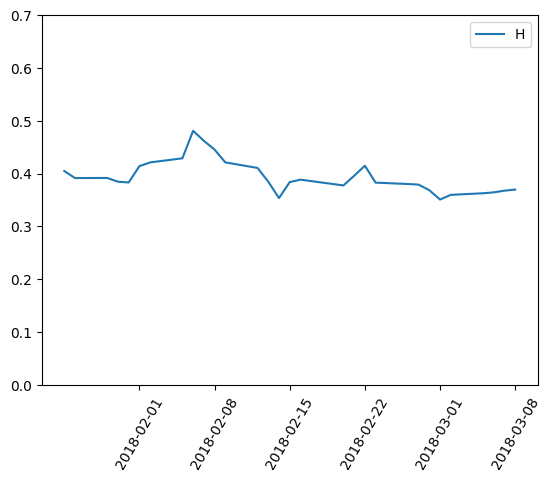

In [24]:
import matplotlib.pyplot as plt 
df_result['date'] = pd.to_datetime(df_result['date'])

plt.plot(df_result['date'],df_result['H'],label='H')
plt.xticks(rotation=60)
plt.legend()
plt.ylim(0,0.7)
plt.show()

In [25]:
r2 = r2_score(df_result['true'].values,df_result['pred'].values)
r2 

0.24859379584250507

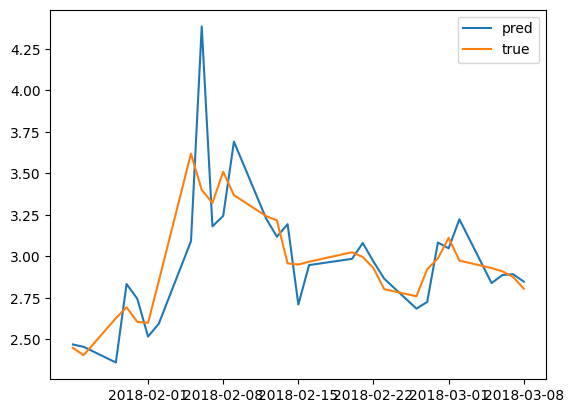

In [26]:
import matplotlib.pyplot as plt
plt.plot(df_result['date'],df_result['pred'],label='pred')
plt.plot(df_result['date'],df_result['true'],label='true')
plt.legend()
plt.show()

In [27]:
from statsmodels.tsa.ar_model import AutoReg

def ar(date):
    df = prepare_data('./data/VIXdata.txt')
    n = 500
    # date = '20120101'
    df_ori = obtain_train_ar(df,n,date)
    acf_params = acf(df_ori['log_vix'],nlags=50)
    model = AutoReg(df_ori['log_vix'], lags=len(acf_params[acf_params>0.5])).fit()
    result = model.forecast(1)

    df_true = obtain_true_ar(df,n+1,date)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
    print(type(result))
    # print()
    return [result.values[-1],date_,true_value,len(acf_params[acf_params>0.5])],model


In [28]:
date_list

['20160201',
 '20160202',
 '20160203',
 '20160204',
 '20160205',
 '20160208',
 '20160209',
 '20160210',
 '20160211',
 '20160212',
 '20160216',
 '20160217',
 '20160218',
 '20160219',
 '20160222',
 '20160223',
 '20160224',
 '20160225',
 '20160226',
 '20160229',
 '20160301',
 '20160302',
 '20160303',
 '20160304',
 '20160307',
 '20160308',
 '20160309',
 '20160310',
 '20160311',
 '20160314']

In [29]:
result_ar = []
for date in date_list:
    result_,model = ar(date)
    result_ar.append(result_)
result_ar
df_result_ar = pd.DataFrame(result_ar,columns=['pred','date','true','K'])

d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = geta

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = geta

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\Anaconda3\envs\aip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
df_result_ar

,pred,date,true,K
0,2.441052,2018-01-25,2.449279,17
1,2.434700,2018-01-26,2.405142,17
2,2.400765,2018-01-29,2.627563,17
3,2.607316,2018-01-30,2.693951,16
4,2.673439,2018-01-31,2.605648,16
5,2.589164,2018-02-01,2.600465,15
6,2.567561,2018-02-02,2.851284,15
7,2.817047,2018-02-05,3.619529,15
8,3.557512,2018-02-06,3.400530,13
9,3.268668,2018-02-07,3.322515,12


In [31]:
model.summary().as_text()

'                            AutoReg Model Results                             \n==============================================================================\nDep. Variable:                log_vix   No. Observations:                  500\nModel:                    AutoReg(12)   Log Likelihood                 531.430\nMethod:               Conditional MLE   S.D. of innovations              0.081\nDate:                Wed, 12 Oct 2022   AIC                          -1034.861\nTime:                        21:51:19   BIC                           -976.197\nSample:                            12   HQIC                         -1011.817\n                                  500                                         \n===============================================================================\n                  coef    std err          z      P>|z|      [0.025      0.975]\n-------------------------------------------------------------------------------\nconst           0.1363      0.050   

In [32]:
df_result_ar['date'] = pd.to_datetime(df_result_ar['date'])

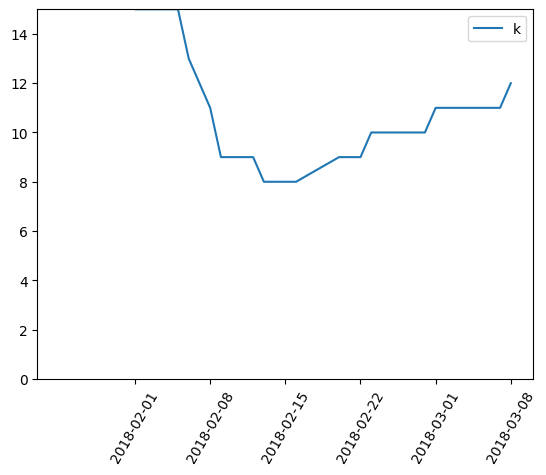

In [33]:
import matplotlib.pyplot as plt
plt.plot(df_result_ar['date'],df_result_ar['K'],label='k')
plt.xticks(rotation=60)
plt.legend()
plt.ylim(0,15)
plt.show()

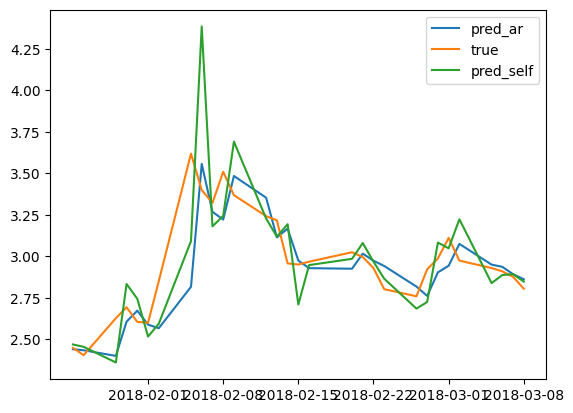

In [34]:
plt.plot(df_result_ar['date'],df_result_ar['pred'],label='pred_ar')
plt.plot(df_result_ar['date'],df_result_ar['true'],label='true')
plt.plot(df_result_ar['date'],df_result['pred'],label='pred_self')
plt.legend()
plt.show()

In [35]:
r2_ar = r2_score(df_result_ar['true'].values,df_result_ar['pred'].values)
r2_ar

0.5671071223224049

In [36]:
df_result_ar['err'] = abs(df_result_ar['pred']-df_result_ar['true'])

In [37]:
(df_result_ar['err']*df_result_ar['err']).mean()

0.036436091639417696

In [38]:
df_result['err'] = abs(df_result['pred']-df_result['true'])
(df_result['err']*df_result['err']).mean()

0.06324498906054994

In [39]:
df_result['err'].mean()

0.16283353269762976

In [40]:
df_result_ar['err'].mean()

0.1204735628901736

In [41]:
from sklearn.metrics import r2_score

In [42]:
r2_score(df_result['true'],df_result['pred'])

0.24859379584250507

In [43]:
r2_score(df_result_ar['true'],df_result_ar['pred'])

0.5671071223224049

In [44]:
def hmse(y_true,y_pred):
    ratio = y_pred/y_true

    # print(ratio[abs(ratio)<2])
    return np.mean(np.power((ratio[abs(ratio)<2]-1),2))

def hmae(y_true,y_pred):
    ratio = y_pred/y_true

    # print(ratio[abs(ratio)<2])
    return np.mean(abs(ratio[abs(ratio)<2]-1))

In [45]:
hmse(df_result_ar['true'],df_result_ar['pred'])

0.003296849519456023

In [46]:
hmae(df_result_ar['true'],df_result_ar['pred'])

0.038728120519252424

In [47]:
hmse(df_result['true'],df_result['pred'])

0.005933175036764839

In [48]:
hmae(df_result['true'],df_result['pred'])

0.05258087911605206

In [49]:
pd.DataFrame([[hmse(df_result['true'],df_result['pred']),
              hmae(df_result['true'],df_result['pred']),
              hmse(df_result_ar['true'],df_result_ar['pred']),
              hmae(df_result_ar['true'],df_result_ar['pred']),
              r2_score(df_result['true'],df_result['pred']),
              r2_score(df_result_ar['true'],df_result_ar['pred'])
              ]],columns = ['hmse_','hmae','hmse_ar','hmae_ar','r2_','r2_ar'])

,hmse_,hmae,hmse_ar,hmae_ar,r2_,r2_ar
0,0.005933,0.052581,0.003297,0.038728,0.248594,0.567107


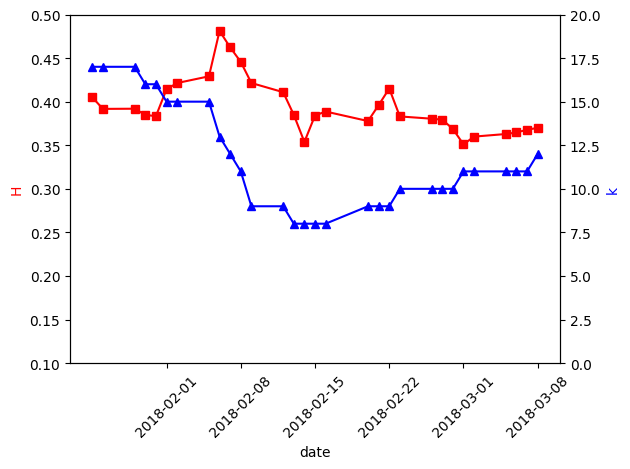

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

# color = 'green'
ax1.set_xlabel('date')
# ax1.set_xticks(ratation=60)
ax1.set_ylabel('H',color='r')
ax1.plot(df_result['date'], df_result['H'],'-s',color='r')
ax1.tick_params(axis='y')
ax1.set_ylim((0.1,0.5))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('k',color='b')  # we already handled the x-label with ax1
ax2.plot(df_result_ar['date'], df_result_ar['K'],'-^',color='b')
ax2.tick_params(axis='y')
ax2.set_ylim((0,20))

for tl in ax1.get_xticklabels():
    tl.set_rotation(45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig("./H_k.png",dpi=200)
plt.show()

In [51]:
# import numpy as np
# import matplotlib.pyplot as plt

# def function(x, p):
#     return x ** (2 * p + 1) / (1 + x ** (2 * p))

# pparam = dict(xlabel='Voltage (mV)', ylabel='Current ($\mu$A)')

# x = np.linspace(0.75, 1.25, 201)
# with plt.style.context(['science']):
#     fig, ax = plt.subplots()
#     for p in [10, 15, 20, 30, 50, 100]:
#         ax.plot(x, function(x, p), label=p)
#     ax.legend(title='Order')
#     ax.autoscale(tight=True)
#     ax.set(**pparam)
#     # fig.savefig('figures/fig1.pdf')
#     # fig.savefig('figures/fig1.jpg', dpi=300)
